# Studienarbeit ComputerVision 2
## Differences and Limitations of Unet and SegNet

---

In [1]:
# relevant imports
import os
from torch import nn, optim
from torchsummary import summary
from datasets import load_dataset
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from ray import tune
from functools import partial
from ray.air import session
from ray.train import Checkpoint
from monai.losses import DiceLoss
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
from typing import List
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import torch
from monai.metrics import MeanIoU
from monai.transforms import Activations, AsDiscrete


#### Modelarchitecture
![unet_brain_mri.png](https://pytorch.org/assets/images/unet_brain_mri.png)

In [19]:
class UNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(UNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = UNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_2 = UNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_3 = UNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_4 = UNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottle_neck_block = UNet._conv_block(256, 512)

        # Decoder Blocks
        self.upconv_block_4 = UNet._upconv_block(512, 256)
        self.decoder_block_4 = UNet._conv_block(512, 256)

        self.upconv_block_3 = UNet._upconv_block(256, 128)
        self.decoder_block_3 = UNet._conv_block(256, 128)

        self.upconv_block_2 = UNet._upconv_block(128, 64)
        self.decoder_block_2 = UNet._conv_block(128, 64)

        self.upconv_block_1 = UNet._upconv_block(64, 32)
        self.decoder_block_1 = UNet._conv_block(64, 32)

        # Output convolution
        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e2 = self.encoder_block_2(self.max_pool_1(e1))
        e3 = self.encoder_block_3(self.max_pool_2(e2))
        e4 = self.encoder_block_4(self.max_pool_3(e3))

        b = self.bottle_neck_block(self.max_pool_4(e4))

        d4 = self.upconv_block_4(b)
        d4 = self.decoder_block_4(torch.cat((d4, e4), dim=1))
        d3 = self.upconv_block_3(d4)
        d3 = self.decoder_block_3(torch.cat((d3, e3), dim=1))
        d2 = self.upconv_block_2(d3)
        d2 = self.decoder_block_2(torch.cat((d2, e2), dim=1))
        d1 = self.upconv_block_1(d2)
        d1 = self.decoder_block_1(torch.cat((d1, e1), dim=1))

        return self.fc(d1)

    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

    @staticmethod
    def _upconv_block(input_size, output_size):
        return nn.ConvTranspose2d(input_size, output_size, kernel_size=2, stride=2)

In [65]:
# Load U-Net
unet = UNet(3, 1)
unet.cuda()
summary(unet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

---

#### Datapreparation

In [3]:
isic18_dataset = load_dataset("surajbijjahalli/ISIC2018")
isic18_dataset

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2594
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [4]:
class ISICDataset(Dataset):
    def __init__(self, dataset, transform_image=None, transform_mask=None):
        self.dataset = dataset
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        image = example['image']
        mask = example['label']
        mask = mask.convert('L')
        mask = np.array(mask)
        mask[mask > 0] = 255
        mask[mask == 0] = 0
        mask = Image.fromarray(mask)

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

In [5]:
transform_image = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()])

isic18_train_dataset = ISICDataset(isic18_dataset['train'].select(range(100)), transform_image, transform_mask)
isic18_val_dataset = ISICDataset(isic18_dataset['validation'], transform_image, transform_mask)
isic18_test_dataset = ISICDataset(isic18_dataset['test'], transform_image, transform_mask)

---

#### Training

In [15]:
def validation_loop(model: nn.Module, validation_dataloader: DataLoader, loss_fn, device) -> float:
    """
    Validation loop for the CNN
    :param model: neural network
    :param validation_dataloader: dataloader for the validation set
    :param loss_fn: loss function
    :param device: device on which to perform the validation
    :return: validation loss
    """
    running_val_loss: float = 0.
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            inputs, targets = vdata
            inputs, targets = inputs.to(device), targets.to(device)

            vloss = loss_fn(model(inputs), targets)
            running_val_loss += vloss.item()
        running_val_loss /= (i + 1)

    return running_val_loss


In [16]:
def train_loop(model: nn.Module, train_dataloader: DataLoader, loss_fn, optimizer, device) -> float:
    """
    Main minibatch train loop for the CNN
    :param model: neural network
    :param train_dataloader: dataloader for the train set
    :param loss_fn: loss function
    :param optimizer: optimizer
    :param device: device on which to perform the training
    :return: train loss
    """
    running_tr_loss: float = 0.
    for i, data in enumerate(train_dataloader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        yhats = model(inputs)
        optimizer.zero_grad()
        tloss = loss_fn(yhats, targets)

        tloss.backward()
        optimizer.step()

        running_tr_loss += tloss.item()
    running_tr_loss /= (i + 1)

    return running_tr_loss


In [17]:
def train_unet(
        config: dict,
        train_dataset: datasets,
        validation_dataset: datasets,
        epochs: int,
        apply_scheduler: bool = True,
        return_flag: bool = False) -> dict | None:
    """
    Prepared train loop for ray parameter tuning.
    Training components:
        - model: CNN
        - loss function: CrossEntropyLoss
        - optimizer: Adam
        - scheduler: ExponentialLR (optional)

    :param config: dict of hyperparameters
    :param train_dataset:
    :param validation_dataset:
    :param epochs: number of epochs to train
    :param apply_scheduler: weather scheduler should be used or not
    :param return_flag: weather to return the model and losses or not
    :return: training results
    """

    device: torch.device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
    print(device)
    model: nn.Module = UNet(3, 1).to(device)

    loss_fn = DiceLoss(sigmoid=True)

    optim_params: dict = {
        'lr': config["lr"]
    }
    optimizer: optim.Adam = optim.Adam(model.parameters(), **optim_params)

    scheduler_params: dict = {
        'gamma': config['gamma'],
        'verbose': False
    }
    scheduler: ExponentialLR = ExponentialLR(optimizer, **scheduler_params)

    train_dataloader: DataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    validation_dataloader: DataLoader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)

    train_losses: List[float] = []
    val_losses: List[float] = []

    print('Start training...')
    for epoch in tqdm(range(epochs)):
        print('Start: ', epoch)
        model.train()

        # Train loop to iterate over the dataloader batches
        running_tr_loss: float = train_loop(model, train_dataloader, loss_fn, optimizer, device)
        if apply_scheduler:
            scheduler.step()

        # Validation loop
        running_val_loss: float = validation_loop(model, validation_dataloader, loss_fn, device)

        print(epoch, " - ", 'tr_loss:', running_tr_loss, 'val_loss:', running_val_loss)
        train_losses.append(running_tr_loss)
        val_losses.append(running_val_loss)

        # Save a checkpoint from the model
        os.makedirs("res/model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "res/model/checkpoint1.pt")
        checkpoint: Checkpoint = Checkpoint.from_directory("res/model")
        session.report({"val_loss": running_val_loss,
                        "train_loss": running_tr_loss}, checkpoint=checkpoint)

    if return_flag:
        return {"train_losses": train_losses,
                "val_losses": val_losses,
                "model": model}

---

#### Parametertuning

In [ ]:
EPOCHS = 20
partial_model_train = partial(train_unet, epochs=EPOCHS)

config = {
    "lr": tune.loguniform(1e-4, 1e0),
    "gamma": tune.uniform(0.9, 0.99999),
}


tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(partial_model_train,
                                 train_dataset=isic18_train_dataset,
                                 validation_dataset=isic18_val_dataset),
            resources={"GPU": 1}),

        tune_config=tune.TuneConfig(metric="val_loss",
                                    mode="min",
                                    num_samples=5),

        param_space=config)

In [ ]:
results = tuner.fit()

---

#### Training with Parameter

In [ ]:
best_trial = results.get_best_result("val_loss", "min", "last")
best_trial.config

In [18]:
config = {'lr': 0.0011075820407299578, 'gamma': 0.9596539000640568}

res = train_unet(config, isic18_train_dataset, isic18_val_dataset, 50, return_flag=True, apply_scheduler=True)

cuda:6


/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Start training...


  0%|          | 0/50 [00:00<?, ?it/s]

Start:  0


  0%|          | 0/50 [00:02<?, ?it/s]


AttributeError: 'UNet' object has no attribute 'upconv_block_4'

In [97]:
val_losses = res['val_losses']
tr_losses = res['train_losses']
model = res['model']

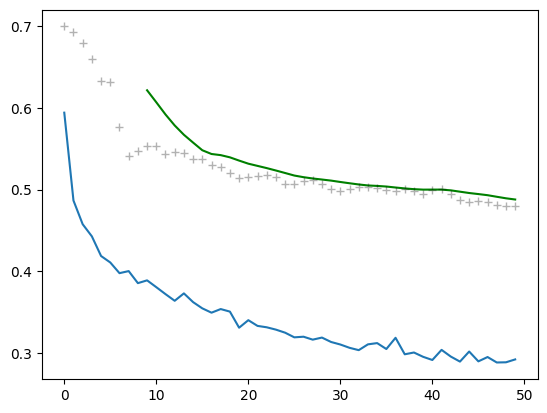

In [98]:
plt.plot(tr_losses)
plt.plot(pd.Series(val_losses).rolling(10).mean(), color='g')
plt.plot(val_losses, 'k+', alpha=0.3)
plt.show()

---

#### Evaluation

In [99]:
torch.save(model, '../../res/checkpoints/unet_isic18_500_full.pt')
torch.save(model.state_dict(), '../../res/checkpoints/unet_isic18_100.pt')

In [20]:
def load_checkpoint(path: Path, model: torch.nn.Module) -> torch.nn.Module:
    """
    Helper method to load a model from a checkpoint
    :param path: path to checkpoint
    :param model: model which should use the checkpoint
    :return: loaded model
    """
    device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

In [21]:
test_dataloader = DataLoader(isic18_test_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = UNet(3, 1).to(device)

net = load_checkpoint(Path('../../res/checkpoints/unet_isic18_500.pt'), net)

In [22]:
def evaluate_model(model: torch.nn.Module, data_loader: DataLoader, device) -> None:
    """
    Evaluate the pixel accuracy for binary segmentation.
    :param model: neural network
    :param data_loader: torch Dataloader
    :param device: device on which to perform the evaluation
    :return: None
    """
    total_correct_pixels = 0
    total_pixels = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).cpu().numpy()

            targets = targets.numpy().flatten()
            preds = preds.flatten()

            correct_pixels = np.sum(preds == targets)
            total_pixels += targets.size
            total_correct_pixels += correct_pixels

    pixel_accuracy = total_correct_pixels / total_pixels
    print('Pixel Accuracy: ', pixel_accuracy)

In [23]:
evaluate_model(net, test_dataloader, device)

100%|██████████| 16/16 [02:37<00:00,  9.82s/it]

Pixel Accuracy:  0.7298862915039063


In [24]:
def evaluate_binary_mean_iou(model, dataloader, device) -> float:
    """
    Evaluate the Mean IoU for binary segmentation.
    :param model: neural network
    :param dataloader: Torch Dataloader
    :param device: device on which to perform the evaluation
    :return: mean IoU
    """
    mean_iou_metric = MeanIoU(include_background=True, reduction="mean")
    activation = Activations(sigmoid=True)
    discretize = AsDiscrete(threshold=0.5)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            preds = activation(outputs)
            preds = discretize(preds)

            mean_iou_metric(y_pred=preds, y=targets)

    mean_iou = mean_iou_metric.aggregate().item()
    print(f"Mean IoU: {mean_iou}")
    return mean_iou


In [25]:
evaluate_binary_mean_iou(net, test_dataloader, device)

100%|██████████| 16/16 [01:51<00:00,  6.96s/it]

Mean IoU: 0.5403781533241272


0.5403781533241272